# Welcome to Week 2!

## Prerequisites:

Run the below cell to install the dependencies for this project and mount the drive:

In [ ]:
%%capture
!pip install numpy pandas matplotlib emoji==1.6.3 torch lrcurve gradio wandb fsspec dask[bag]

In [ ]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive', force_remount=False)

#@markdown Specify the full "DLE-Projects" folder in your Google Drive.
#@markdown You can find this by navigating in the folder icon tab on the left.
directory = '/content/drive/MyDrive/DLE-Projects/' #@param {type:"string"}

sys.path.append(directory)
sys.path.append(os.path.join(directory, 'utils'))
os.chdir(os.path.join(directory, 'Week2'))
%matplotlib inline

# This is the directory that local changes get saved to.
# Change this if you'd like to save them somewhere else!
os.chdir('/content/drive/MyDrive/Colab Notebooks/')


Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2
import gradio as gr
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
import emoji
import wandb
import pandas as pd
import lrcurve
from functools import partial
from scipy.special import softmax
from sklearn.metrics import accuracy_score, f1_score, classification_report

import constants as const
from utils import *
from quickdraw import *
from assignment_helpers import *

torch.manual_seed(0)
import random
random.seed(0)

# Week 2 - Training Neural Networks

Welcome back!

This week, we are extending our knowledge of neural networks and PyTorch by creating an end-to-end deep learning training/evaluation pipeline. We will be using an object doodle database and create our own sketch-to-emoji app!

## Overview of Week 2

1. The QuickDraw dataset
2. Dataloaders
3. Training the model
  - `zero_grad()`
  - `backward()`
  - `step()`
4. Monitoring
  - Weights and Biases
  - Evaluation
5. Optimizers
6. Model Improvements

## Doodle to Emoji Demo App
Let's say you're working for a mobile messaging company. You've noticed how much time people spend trying to find the right emoji, scrolling endlessly through the options given in the keyboard. Sometimes, even searching for it using keywords doesn't give you what you want!

To solve this, you've taken it on your own to create a way for users to just *draw* the emoji they want!

**Using a neural network, develop a model that can translate a user-drawn doodle into its corresponding emoji.**


<img src="https://drive.google.com/uc?id=1XGb5lO0t-vAx7rSs_LUVHngFTbfdlrr8" width="600">

You've been given the user interface below, and your job is to train ```model``` such that it gives accurate results. Currently, ```model``` is just a dummy function, but feel free to try out the interface! (The predictions will just be placeholders).

To make things a little simpler, we will focus on emojis for this project. However, you can scale to hundreds using the same approach.

The ten emojis are:

    smile 😄. eyes 👀, car 🚗, star ⭐, stop sign 🛑, bed 🛏️, baseball ⚾, basketball 🏀, pizza 🍕, bicycle 🚲


In [ ]:
def model(doodle):
  '''
  A placeholder for your model!
  This function returns equal probability to each of the ten classes above.
  '''
  return np.array([0.1]*10)

def predict(doodle):
    doodle = doodle / 255.
    y_hats = model(doodle)
    emoji_names = np.array(list(const.DOODLE_TO_EMOJI_MAP.values()))
    emoji_dict = {emoji.emojize(f':{emoji_names[i]}:', use_aliases=True): float(y_hat) \
                  for i, y_hat in enumerate(y_hats)}
    return emoji_dict

interface = gr.Interface(predict, inputs='sketchpad', outputs='label', theme="default", live=True, description="Guess the Doodle!")
interface.launch(debug=True)

Hint: Set streaming=True for Sketchpad component to use live streaming.
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://d2e3e74983d9d708.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f43fd873950>,
 'http://127.0.0.1:7860/',
 'https://d2e3e74983d9d708.gradio.app')

Our goal for this week is to populate ```model()``` with a working emoji classifier from scratch by:
1. Loading the QuickDraw dataset
2. Creating our own MLP model
3. Training the model
4. Optimizing the model

# 1. The QuickDraw Dataset

For this project, we will be using the [Quick Draw dataset](https://www.kaggle.com/c/quickdraw-doodle-recognition/data) from Google Research, which contains human-drawn doodles from over 300 categories (we'll just be working with 10 this week).

Here, we provide you with a few helper functions to access the dataset, located in the `quickdraw.py` file in the `utils/` folder.

`download_quickdraw_dataset(data_dir, class_names)`: This function downloads each of the classes listed in `class_names` as Numpy files from a Google Storage bucket and saves them into `data_dir`.

`load_quickdraw_data(data_dir, class_names, max_items_per_class)`: This function reads the Numpy files from `data_dir` for each of the classes in `class_names` (up to `max_items_per_class` number of examples). Returns the images and labels as a tuple `(X, y)`.

We encourage you to open up `quickdraw.py` and take a look at what they do!

**TODO**: Use the two functions above to download the data and load it into variables `X` (the images) and `Y` (the labels). Print the shapes of both variables.

Hint: `const.DOODLE_TO_EMOJI_MAP` is a dictionary with the keys as the dataset class names and the values as the corresponding emoji names. Use `list(const.DOODLE_TO_EMOJI_MAP.keys())` to get a list of class names.

In [ ]:
data_dir = './data'
max_items_per_class = 20000 # to retreive equal samples for each class
# TODO: Load the names of classes
class_names = list(const.DOODLE_TO_EMOJI_MAP.keys())
print(f'Class Names: {class_names}')

# TODO: Download the dataset
download_quickdraw_dataset(data_dir, class_names)

# TODO: Load the images and labels
X, Y = load_quickdraw_data(data_dir, class_names, max_items_per_class)

# TODO: Print the shapes of X and Y
print(f"Shape of X, {X.shape}")
print(f"Shape of Y, {Y.shape}")

Class Names: ['smiley face', 'stop sign', 'baseball', 'basketball', 'bed', 'bicycle', 'eye', 'car', 'pizza', 'star']


  0%|          | 0/10 [00:00<?, ?it/s]

Loading 20000 examples for each class from the Quickdraw Dataset...
Shape of X, (200000, 784)
Shape of Y, (200000,)


In [ ]:
#@title Run this cell to check your answer!

check_answer(X.shape == (200000, 784) and Y.shape == (200000,))

## Correct! 🎉

## The `Dataset` class

As you might imagine, loading data is a big part of training a neural network. To make things easier, PyTorch has a whole class defined that just deals with loading data for the neural network.

This class is called a [PyTorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). To create a PyTorch Dataset, just create a class that inherits the `torch.utils.data.Dataset` abstract class. There are a lot of methods that come along for the ride, but the two that you need to override to customize any PyTorch Dataset are:

- `__len__` so that `len(dataset)` returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get `i`th sample.

**TODO**: Create a PyTorch Dataset class. Implement the two methods above and use the `download_quickdraw_dataset` and `load_quickdraw_data` methods in the initialization.

We've included a function, `split()`, which returns three Datasets: a train, validation, and test dataset with the validation and test dataset each containing `pct` percent of the total data and the training data containing the rest.

In [ ]:
import math
from quickdraw import *

class QuickDrawDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir=None, class_names=None):
        super().__init__()

        # TODO: Initialize data_dir, class_names, and num_classes instance variables
        self.data_dir = data_dir
        self.class_names = class_names
        self.num_classes = len(class_names)

        # TODO: Run download_quickdraw_dataset
        download_quickdraw_dataset(data_dir, class_names)

        # TODO: Get and set X, Y
        self.X, self.Y = load_quickdraw_data(data_dir, class_names, max_items_per_class)

    def __getitem__(self, idx):

        # TODO: Get X[idx]
        # TODO: Reshape image to (1, 28, 28)
        # TODO: Convert datatype to np.float32
        # TODO: Normalize image to [0, 1] range
        # TODO: Return cleaned up x, y

        x = X[idx]
        x = np.reshape(x, (1,28,28))
        x = x.astype(np.float32)
        x /= 255
        x = torch.tensor(x)

        y = self.Y[idx]

        return x, y

    def __len__(self):

        # TODO: Return the number of images in X
        len_X = X.shape[0]

        return len_X

    def split(self, pct=0.1, seed=0):

        # Nothing to do here, this function just splits your data

        torch.manual_seed(seed)
        indices = torch.randperm(len(self)).tolist()
        n_pct = math.floor(len(indices) * pct)
        train_ds = torch.utils.data.Subset(self, indices[:-(2*n_pct)])
        val_ds = torch.utils.data.Subset(self, indices[-(2*n_pct):-n_pct])
        test_ds = torch.utils.data.Subset(self, indices[-n_pct:])
        return train_ds, val_ds, test_ds


Now use the `QuickDrawDataset` class to create `train_ds`, `val_ds`, and `test_ds`. Set `pct=0.1`. This will randomly split the entire dataset into 80\% training, 10\% validation, and 10\% testing data.

In [ ]:
# TODO: Load QuickDrawDataset
data_dir = './data'
labels = list(const.DOODLE_TO_EMOJI_MAP.keys())
ds = QuickDrawDataset(data_dir, labels)

# TODO: Partition ds into train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = ds.split(pct=0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading 20000 examples for each class from the Quickdraw Dataset...


In [ ]:
#@title Run this cell to check your answer!

cond1 = train_ds[1000][0].shape == (1, 28, 28)
cond2 = len(train_ds) == 160000
cond3 = int(train_ds[0][0].sum().numpy()) == 109
cond4 = int(val_ds[0][0].sum().numpy()) == 131
cond5 = int(test_ds[0][0].sum().numpy()) == 100

check_answer(cond1 and cond2 and cond3 and cond4 and cond5)

## Correct! 🎉

**TODO:** Now, using the training dataset, visualize the first 10 doodles and print the class name. A `Dataset` object can be accessed in two days:

- Access a specific index or range of indices, just as you would with a list.
- A dataset is `Iterable`, meaning you can use it in a loop:

        for data, label in train_ds:
          ...




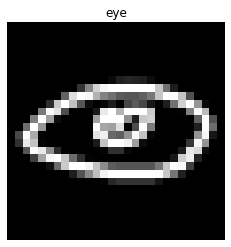

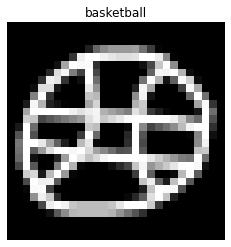

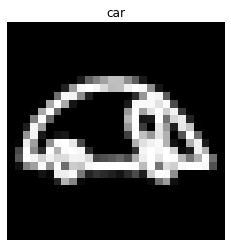

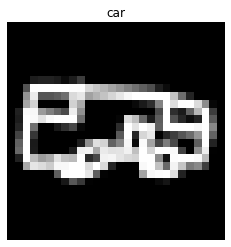

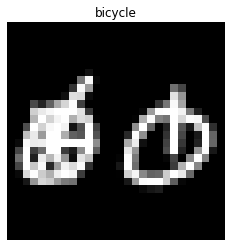

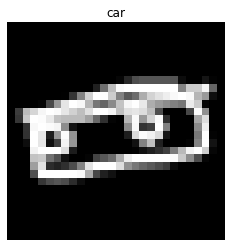

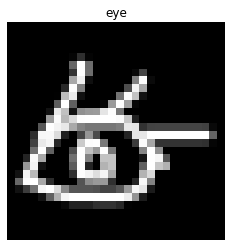

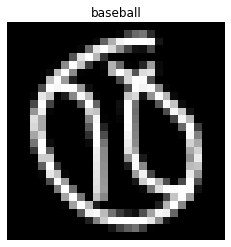

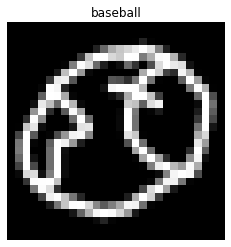

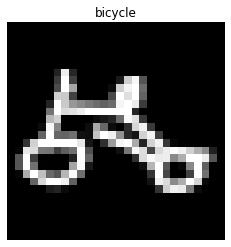

In [ ]:
# TODO: Iterate through train_ds, displaying the image using plt.imshow() and printing the class
# No answer checking here, you'll know you've done it right when you see 10 images with labels!

for i in range(10):
  img, label = train_ds[i]
  plt.title(class_names[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

## The `DataLoader` class
Next, we will create a `DataLoader` object. Since deep learning models are typically trained in batches of data points, the `DataLoader` acts as a wrapper over the `Dataset` object and automatically aggregates data points into batches. It also can perform other useful functions like randomly shuffling the data points.

Take a second and read over the PyTorch documentation for DataLoaders to get a sense of the API:

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


**TODO**: Now, using the `QuickDrawDataset` class we mentioned above, create three `DataLoader` objects: one for training (call it `train_dataloader`), one for validation (`val_dataloader`), and one for testing (`test_dataloader`). (We've included the code for `train_dataloader`). Set the batch size as a variable `batch_size` to 64 and `shuffle=True`.

In [ ]:
# TODO: Create three DataLoader objects
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [ ]:
#@title Run this cell to check your answer!
torch.manual_seed(0)
cond1 = batch_size == 64
d = next(iter(train_dataloader))
cond2 = d[0].shape == (64, 1, 28, 28)
cond3 = len(train_dataloader) == 2500
cond4 = len(val_dataloader) == 313
cond5 = len(test_dataloader) == 313
check_answer(cond1 and cond2 and cond3 and cond4 and cond5)

## Correct! 🎉

## Visualizing emojis

Currently, the `Dataset` labels are simply indices corresponding to the class names. We want a way to print and represent emojis in code (specifically, Unicode). Thankfully, we can use the `emoji` package!

The function `emoji.emojize()` takes in an emoji code and converts it to the unicode representation.

Feel free to search up an emoji here (https://www.webfx.com/tools/emoji-cheat-sheet/) and see what it looks like printed out in the line commented out below.

**TODO**: Using the `emoji` package, print all 10 emoji classes listed above.

Hint: Use `list(const.DOODLE_TO_EMOJI_MAP.values())` to get the emoji class names.

To print the smile emoji, use `emoji.emojize(f':smile:', use_aliases=True)`.

In [ ]:
# TODO: Using a for-loop print each emoji class name followed by the emoji.
emoji_names = list(const.DOODLE_TO_EMOJI_MAP.values())
for name in emoji_names:
  print(emoji.emojize(f':{name}:', use_aliases=True))

😄
🛑
⚾
🏀
🛏️
🚲
👀
🚗
🍕
⭐


Cool! Now that we can generate data in batches and can print emojis, let's get to training our model.

# 2. Training the model
We will be using an MLP network like we did last week. However, we're making a few modifications. First, since the input is a 28x28 px image, we are going to *flatten* the image into a 784-length vector (28x28=784). Second, the last layer will have 10 output features, corresponding to the 10 emoji class labels.


## Creating the `MLP` class

**TODO**: Create a PyTorch model class (call it `MLP`) with the following specifications:
- An input `Flatten` layer
- An linear layer with:
 - 784 input features
 - 64 output features
 - Followed by ReLU activation function
- A second linear layer with:
 - 64 input features
 - 32 output features
 - Followed by ReLU activation function
- An output linear layer with:
 - 32 input features
 - 10 output features
 - No activation function

In [ ]:
# TODO: Create MLP, a class for the model described above
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    # TODO: Create layers here
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(784, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 10)


  def forward(self, x):
    # TODO: Pass x through each layer. Hint:  You'll first need to change the dimension of x!
    x = x.view(-1, 28*28)
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
#@title Run this cell to check your answer!
torch.manual_seed(0)
model = MLP()
sizes = [[64, 784], [64], [32, 64], [32], [10, 32], [10]]
cond = True
for i, parameter in enumerate(model.parameters()):
  if list(parameter.size()) != sizes[i]:
    cond = False
cond = cond and math.isclose(model(train_ds[0][0]).detach().numpy()[0][0], -0.054749712, abs_tol=1e-8)
check_answer(cond)

## Correct! 🎉

## The training loop

The training loop performs 5 steps:

1. Generate a data batch:
  - Using the `train_dataloader` object, generate an `X` and `targets`.

2. Forward pass
  - Make a prediction using your `model` and save the output to a variable `outputs`.

3. Compute loss
  - Use the `loss_fn`  function to compute the loss on `outputs` and `targets`. Store the output as `loss` and print it's value with `loss.item()`.

4. Backpropagation
  - Using this `loss`, we perform backpropagation -- this step computes a gradient for every weight in `model.parameters()` with respect to `loss`. Note: this step doesn't actually update the weights -- it merely stores the gradients in `model.parameters()`.

4. Optimizer step
  - Now, update the weights using the gradient descent optimizer. Note that the optimizer takes as input `model.parameters()` so it has access to the gradients.

5. Zero the gradients
  - This is a clean up step. The gradients stored in step 3 aren't automatically zeroed out, so we need to do this before continuing. If we don't do this step, the gradients are aggregated.

And this completes an entire training step!

**TODO**: Implement the training loop described above as a `train` function.

Hint: Your `train` function should start like this:

`def train(epochs=None, model=None, train_dataloader=None, optimizer=None, loss_fn=None):`

For flexibility, pass in the dataloaders, optimizer, and loss functions as parameters.

Use `torch.optim.Adam` as the optimizer with a learning rate of `1e-4`.

Use `nn.CrossEntropyLoss()` as the loss function.

In [ ]:
def train(epochs=10, model=None, train_dataloader=None, val_dataloader=None, optimizer=None, loss_fn=None):

  # TODO: Create loop over epochs
  for epoch in range(epochs):
    # TODO: Create loop over data batches
    for i, data in enumerate(train_dataloader):
      # TODO: Get x, y from data batch
      x, y = data
      # TODO: Get outputs from model
      outputs = model(x)
      # TODO: Compute loss
      loss = loss_fn(outputs, y)
      # TODO: Run backpropagation
      loss.backward()
      # TODO: Update weights
      optimizer.step()
      # TODO: Reset gradients
      optimizer.zero_grad()
    # TODO: Print loss at the end of every epoch
    print(f'Epoch {epoch} Loss: {loss.item()}')

**TODO**: Train your model for 10 epochs, printing the loss every epoch.


In [ ]:
# TODO: Train model for 10 epochs
model = MLP()

# TODO: Define variables that go into train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Pass in those parameters and run train()
train(model=model, train_dataloader=train_dataloader, optimizer=optimizer, loss_fn=loss_fn)

Epoch 0 Loss: 0.9969456195831299
Epoch 1 Loss: 1.1405991315841675
Epoch 2 Loss: 0.7190476655960083
Epoch 3 Loss: 0.6615115404129028
Epoch 4 Loss: 0.7381364107131958
Epoch 5 Loss: 0.7709081172943115
Epoch 6 Loss: 0.7347870469093323
Epoch 7 Loss: 0.42845484614372253
Epoch 8 Loss: 0.5569443106651306
Epoch 9 Loss: 0.5661107301712036


In [ ]:
#@title Run this cell to check your answer!
#@markdown This could take minute -- we're running diagnostics on your function.
#from train import train
torch.manual_seed(0)
model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#sys.stdout = open(os.devnull, 'w')
train(epochs=1, model=model, train_dataloader=train_dataloader, optimizer=optimizer, loss_fn=loss_fn)
#sys.stdout = sys.__stdout__
cond = math.isclose(model(train_ds[0][0]).detach().numpy()[0][0], -0.239, abs_tol=1e-3)
check_answer(cond)


Epoch 0 Loss: 0.8343640565872192


## Correct! 🎉

# 3. Monitoring

Instead of printing the loss of our model to the console, let's hook it up to an ML monitoring platform. The one we'll be using is **Weights and Biases**,  a cloud platform that makes it easy to keep track of your model's progress and test metrics.

**TODO:** Head over to [wandb.ai](https://wandb.ai) and create an account. We recommend using your Github account if you have one!

Execute the following cell to initialize a new run under the specific project name. When a run is initiated, a link to the run dashboard will be returned. Navigate there to check it out!

In [ ]:
import wandb
wandb.init(project="deep-learning-essentials")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


W&B can be directly called anywhere in your training loop.
The `log` function is flexible; it takes a dictionary and can log loss values, images, and even tables.

```wandb.log({"loss": loss})```

W&B also keeps track of hyperparameters associated with the run. This can be done at initialization:

```wandb.init(config={"batch_size": 32})```

Or, you can also directly set each hyperparameter in two ways:

```wandb.config.lr = 0.1```

```wandb.config.update({"lr": 0.1})```

We highly recommend that you check out the complete documentation [for the W&B PyTorch API](https://docs.wandb.ai/guides/track).

**TODO**: Add WandB logging into your training loop, logging the current loss every 100 steps (steps are every time the neural network weights are updated):

In [ ]:
def train(epochs=10, model=None, train_dataloader=None, val_dataloader=None, optimizer=None, loss_fn=None, use_wandb=False):

  # TODO: Run the wandb.init function if use_wandb is set True
  if use_wandb:
    print("Using wandb")
    wandb.init(config = {"batch_size":64, "lr": 1e-4})
  step = 0

  ########## Copy&paste your code from the previous train function ##########
  ##########     You can delete the print statement from earlier.  ##########
  for epoch in range(epochs):
    # TODO: Create loop over data batches
    for i, data in enumerate(train_dataloader):
      # TODO: Get x, y from data batch
      x, y = data
      # TODO: Get outputs from model
      outputs = model(x)
      # TODO: Compute loss
      loss = loss_fn(outputs, y)
      # TODO: Run backpropagation
      loss.backward()
      # TODO: Update weights
      optimizer.step()
      # TODO: Reset gradients
      optimizer.zero_grad()
      step +=1
      # TODO: Use wandb.log() to store the loss every 100 steps.
      if step % 100 == 0:
        wandb.log({"loss":loss})

In [ ]:
# TODO: Using the same code as before, train your model for 10 epochs, only this time with use_wandb=True!

model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Pass in those parameters and run train()
train(model=model, train_dataloader=train_dataloader, optimizer=optimizer, loss_fn=loss_fn, use_wandb=True)

Using wandb


## Evaluation (validation and testing)

Let's finish out the ML development pipeline by adding code for evaluating the trained model on the test dataset.

Whenever we train models that we evaluate across multiple hyerparameter values, we need to use a held-out *validation* data set. This data set is formally considered a part of the training set, but it is only used to evaluate the model's performance as it is training. Typically, a model will be evaluated on the validation data set at a fixed interval during training, and then the model state that produced the highest validation performance across all hyperparameter values is chosen. Only then do we freeze this model and evaluate it on the test set.

So first, let's incorporate the validation test set into the training pipeline.

**TODO**: Create a function, `evaluate()`, which takes as input the model and a dataloader. This function should evaluate the model using a dataloader and return the [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) on the dataset.

In [ ]:
def evaluate(model, dataloader, metric=accuracy_score):

  # Initialize lists to store model outputs and the true labels
  outputs = []
  targets = []

  # TODO: Iterate through dataloader
  for i, data in enumerate(dataloader):
    x, y = data
    # TODO: Get model outputs and store in outputs
    y_hat = model(x).detach().numpy()
    outputs.extend(y_hat)
    # TODO: Store the targets (labels) in targets
    targets.extend(y.detach().numpy())
    # Note: You need to convert outputs and labels into numpy arrays!
    # Note 2: You'll also need to reshape arrays for this to work!

  # TODO: Compute metric_result given outputs and labels
  # TODO: If no metric is specified, default to using accuracy_score()
  # TODO: Return metric result
  metric_result = metric(targets, np.argmax(outputs, axis=1))
  return metric_result

In [ ]:
def train(epochs=10, model=None, train_dataloader=None, val_dataloader=None, optimizer=None, loss_fn=None, use_wandb=False):

  ########## Copy&paste your code from the most recent train function ##########
  if use_wandb:
    print("Using wandb")
    wandb.init(config = {"batch_size":64, "lr": 1e-4})
  step = 0

  for epoch in range(epochs):
    # TODO: Create loop over data batches
    for i, data in enumerate(train_dataloader):
      # TODO: Get x, y from data batch
      x, y = data
      # TODO: Get outputs from model
      outputs = model(x)
      # TODO: Compute loss
      loss = loss_fn(outputs, y)
      # TODO: Run backpropagation
      loss.backward()
      # TODO: Update weights
      optimizer.step()
      # TODO: Reset gradients
      optimizer.zero_grad()
      step +=1
      # TODO: Use wandb.log() to store the loss every 100 steps.
      if step % 100 == 0:
        wandb.log({"loss":loss})
  ########## ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ##########
    # TODO: Compute and log the evaluation results as "val_acc"
    # Note: Make sure to check that val_dataloader exists and use_wandb is True before doing so.
    if val_dataloader and use_wandb:
      val_acc = evaluate(model, val_dataloader, accuracy_score)
      print(f"Finished epoch {epoch}, val_acc: {val_acc}")
      wandb.log({"val_accuracy": val_acc})

In [ ]:
#@title Run this cell to check your answer!
torch.manual_seed(0)
mlp = MLP()
score = evaluate(model=mlp, dataloader=test_dataloader)
check_answer(math.isclose(score, 0.10175, abs_tol=1e-7))

## Correct! 🎉

**TODO**: Then, call `evaluate` on the validation dataset at the end of every epoch in your `train` function. Log the validation accuracy to W&B. After the training loop finishes, call `evaluate` on the test dataset and log the test accuracy to W&B. Finally, save the model using the following line:

`torch.save(model, 'mlp.pt')`

In [ ]:
# TODO: Copy&paste same code to train your model for 10 epochs, with use_wandb=True

model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Pass in those parameters and run train()
train(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, optimizer=optimizer, loss_fn=loss_fn, use_wandb=True)

# TODO: Use evaluate() to compute the accuracy on the test set.
test_acc = evaluate(model=model, dataloader=test_dataloader)

# TODO: Use wandb.log(), save the test accuracy as "test_acc"
wandb.log({"test_acc": test_acc})

# Save the model as 'mlp.pt'
torch.save(model, 'mlp.pt')

Using wandb


loss,█▄▄▄▃▃▄▃▂▄▃▂▃▃▂▄▃▃▃▁▁▂▃▃▂▁▁▂▃▂▂▂▂▂▂▁▂▁▁▁
loss,0.44251


Finished eopch 0, val_acc: 0.69115
Finished eopch 1, val_acc: 0.7151
Finished eopch 2, val_acc: 0.7385
Finished eopch 3, val_acc: 0.7523
Finished eopch 4, val_acc: 0.7663
Finished eopch 5, val_acc: 0.7732
Finished eopch 6, val_acc: 0.78195
Finished eopch 7, val_acc: 0.78805
Finished eopch 8, val_acc: 0.79375
Finished eopch 9, val_acc: 0.79885


Great job! We've now finished the full neural network training and evaluation pipeline. So far, we've only used the default settings for the loss function, metric, and optimizer. You can try to play around with variations of these to improve your model!

# 4. Optimizers

Optimizers are algorithms that perform the actual updating of the weights. In our example above, we used Adam, a variant of Stochastic Gradient Descent. SGD performs a simple linear scaling on the gradient to update each weight.

**TODO**: Using any resources you'd like, answer the following questions:

In [ ]:
from IPython.display import display, Markdown
#@title Concept check #3: { vertical-output: true, form-width: "500px" }
#@markdown
#@markdown ####  Which of the following statements are true?

#@markdown Momentum-based optimizers determines the weight update value as a linear combination of the gradient and the previous update.
Answer1 = True #@param {type:"boolean"}

#@markdown Stochastic gradient descent uses first-order momentum.
Answer2 = False #@param {type:"boolean"}

#@markdown All gradient descent algorithms asymptotically approach the global minimum of the loss function.
Answer3 = False #@param {type:"boolean"}

#@markdown (Run cell to submit.)

if Answer1:
  display(Markdown('''
  ### ***Answer 1 is correct!***
  '''))
else:
  display(Markdown('### Answer 1 is incorrect, try again!'))

if not Answer2:
  display(Markdown('''
  ### ***Answer 2 is correct!***
  SGD does not use momentum in its update calculations. Adam, a popular momentum-based optimizer, uses first-order gradients to compute update values.
  '''))
else:
  display(Markdown('### Answer 2 is incorrect, try again!'))

if not Answer3:
  display(Markdown('''
  ### ***Answer 3 is correct!***
  Gradient descent algorithms are not guaranteed to find global minima (only local minima!). In fact, with complex neural networks, it is unlikely -- rather, a good local approximation is found instead.
  '''))
else:
  display(Markdown('### Answer 2 is incorrect, try again!'))


  ### ***Answer 1 is correct!*** 
  


  ### ***Answer 2 is correct!*** 
  SGD does not use momentum in its update calculations. Adam, a popular momentum-based optimizer, uses first-order gradients to compute update values.
  


  ### ***Answer 3 is correct!*** 
  Gradient descent algorithms are not guaranteed to find global minima (only local minima!). In fact, with complex neural networks, it is unlikely -- rather, a good local approximation is found instead.
  

# 5. Model improvements

The last part this week will cover techniques for improving model performance. Though there are numerous tricks and tips that you can try to improve your model:

Model design:
- Increasing number of layers
- Increasing number of nodes per layer

Regularization:
- [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) is a layer that you can add to your model. The layer doesn't contain any weights -- in fact, it's only function is to randomly zero-out a fraction of the weights coming from the previous layer.
- Weight decay (L2) adds a penalty term proportional to the size of the weights in the model. The idea here is to ensure that no subset of weights grows too large, which can be a cause of overfitting. In PyTorch, this is done through the `weight_decay` parameter in the optimizer object. For instance, with the Adam optimizer:

    `torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)`

And many others! We encourage you to try out some of the ideas above, or some that you might have discovered yourself.

**TODO**: This last TODO is open-ended: using what we've covered so far, modify the MLP architecture and/or training hyperparameters to achieve a test accuracy of at least ***0.80***. Kudos points if you get higher than this!



In [ ]:
# TODO: Anything and everything you'd like :)

#6. Putting it all together

Congratulations on making it all the way through this project! Let's plug in our model to the demo and give it a test drive now.

### Start the demo:

In [ ]:
def predict(doodle):
    doodle = doodle / 255.
    pt_input = torch.Tensor(doodle).view(1, 1, doodle.shape[0], doodle.shape[1])
    y_hats = model(pt_input).detach().numpy()[0]
    y_hats = softmax(y_hats)
    emoji_names = np.array(list(const.DOODLE_TO_EMOJI_MAP.values()))
    emoji_dict = {emoji.emojize(f':{emoji_names[i]}:', use_aliases=True): float(y_hat) \
                  for i, y_hat in enumerate(y_hats)}
    return emoji_dict

interface = gr.Interface(predict, inputs='sketchpad', outputs='label', theme="default", live=True, description="Guess the Doodle!")
interface.launch(debug=True)

Hint: Set streaming=True for Sketchpad component to use live streaming.
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://622c8105056895d4.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gradio/routes.py", line 285, in run_predict
    fn_index, raw_input, username, session_state, iterators
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 950, in process_api
    result = await self.call_function(fn_index, inputs, iterator)
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 793, in call_function
    block_fn.fn, *processed_input, limiter=self.limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-35-4a83827ae8cd>", line 2, in predict
    doodle = doodle / 255.
T

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f43f0e22a50>,
 'http://127.0.0.1:7860/',
 'https://622c8105056895d4.gradio.app')

### How did you do?

Let's see how well your function does! We've created tiers to show you how well your model is performing:

**S+**: Amazing job! You've done better than the instructors at getting this to work!

**S**: You have incredible intuiiton about neural networks!

**A**: Superb and among the top tier of this class.

**B**: Congrats! You've done as well as any reasonble ML engineer would do on this project!

**C**: There might be some issues with your code since the baseline is higher than the score you got :)

We encourage you to edit your model with all the knowledge that you have now and see how much you can improve your model!


In [ ]:
from IPython.display import display, Markdown as md

#@title How did your model do?
#@markdown Input your final evaluation score (from 0.0 to 1.0) below and see how you performed!
accuracy_score = 0.6 #@param {type:"number"}

tier_dict = {'C': .5, 'B': .7, 'A': .8, 'S': .85, 'S+': .9}
for tier in ['C', 'B', 'A', 'S', 'S+']:
    if accuracy_score < tier_dict[tier]:
        break

display(md(f'## Performance Tier: {tier}.'))
if tier in ['A', 'S', 'S+']:
  display(md(f'Amazing job! Your model has excellent performance.'))
else:
  display(md(f'Great job! Now, see if changing some hyperparameters can improve your model even more!'))

## Performance Tier: B.

Great job! Now, see if changing some hyperparameters can improve your model even more!